# MLS Republic - New RS Retention Stored Procedure - QA
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* June 14, 2022

## Hypothesis
Recently the stored procedure that pulls data for training and scoring the retention model was migrated to RedShift. We are asuming that the logic is still valid and that the data can be used with our existing retention model.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [18]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

from pycaret.classification import *

In [19]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

WBTW-LCBC
Successully logged into Start URL: https://stellaralgo.awsapps.com/start#/


In [20]:
session = boto3.session.Session(profile_name='Stellaralgo-DataScienceAdmin')
client = session.client('redshift')

CLUSTER = 'qa-app'
DBNAME = 'stlrmls'

creds = client.get_cluster_credentials(                
    ClusterIdentifier = CLUSTER,
    DbUser = 'admin',
    DbName = DBNAME,
    DbGroups = ['admin_group'],
    AutoCreate=True
)

# create a connection & cursor and call the stored procedure
conn = psycopg2.connect(
    host = 'qa-app.ctjussvyafp4.us-east-1.redshift.amazonaws.com',
    port = 5439,
    user = creds['DbUser'],
    password = creds['DbPassword'],
    database = DBNAME
)

print(f"GOT CONNECTION TO DATABASE: {CLUSTER} {DBNAME}")

GOT CONNECTION TO DATABASE: qa-app stlrmls


In [21]:
# call the stored proc to get data for the retention model
cur = conn.cursor()
cur.execute(f"CALL dw.getretentionmodeldata(31, 2010, 2022, 'temp_cursor')")

# create a named cursor based on the cursor name passed in above
named_cursor = conn.cursor('temp_cursor')
data = named_cursor.fetchall()

# load the data and columns into a data frame
cols = [row[0] for row in named_cursor.description]
df = pd.DataFrame(data=data, columns=cols)

conn.commit()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11815 entries, 0 to 11814
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   lkupclientid         11815 non-null  int64         
 1   dimcustomermasterid  11815 non-null  int64         
 2   year                 11815 non-null  int64         
 3   productgrouping      11815 non-null  object        
 4   totalspent           11815 non-null  float64       
 5   recentdate           11815 non-null  datetime64[ns]
 6   attendancepercent    11815 non-null  float64       
 7   renewedbeforedays    11815 non-null  int64         
 8   source_tenure        11815 non-null  object        
 9   tenure               11815 non-null  int64         
 10  disttovenue          11815 non-null  float64       
 11  recency              11815 non-null  int64         
 12  missed_games_1       11815 non-null  object        
 13  missed_games_2       11815 non-

In [23]:
# choose the features for the stellar base retention model
features = [
    "dimcustomermasterid",
    "attendancepercent",
    "clicktoopenratio", 
    "clicktosendratio",
    "disttovenue",
    "inperson_contact",
    "isnextyear_buyer",
    "lkupclientid",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "opentosendratio",
    "productgrouping",
    "recency",
    "renewedbeforedays",
    "source_tenure",
    "totalspent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (8559, 18)
Unseen Data For Predictions: (1510, 18)



In [24]:
setup(
    data= df_train, 
    target="isnextyear_buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimcustomermasterid",
        "lkupclientid",
        "productgrouping",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancepercent",
        "disttovenue",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "recency",
        "renewedbeforedays",
        "source_tenure",
        "totalspent"
    ]
);

In [25]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7863,0.7755,0.9263,0.8153,0.8672,0.3304,0.3496,0.3650


In [26]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7747,0.7632,0.9016,0.8182,0.8579,0.3209,0.3299
1,0.7898,0.7669,0.9144,0.8257,0.8678,0.3625,0.3739
2,0.7843,0.7785,0.9215,0.8158,0.8655,0.3322,0.3485
3,0.7775,0.7848,0.9361,0.8016,0.8636,0.2783,0.3051
4,0.7953,0.7794,0.9307,0.8213,0.8725,0.3635,0.3826
5,0.7813,0.7895,0.9197,0.8142,0.8638,0.3200,0.3358
6,0.7937,0.7756,0.9380,0.8159,0.8727,0.3428,0.3673
7,0.7895,0.7750,0.9234,0.8201,0.8687,0.3485,0.3646
8,0.7895,0.7595,0.9380,0.8120,0.8704,0.3251,0.3507
9,0.7868,0.7829,0.9398,0.8085,0.8692,0.3101,0.3378


In [27]:
df_inference = df.loc[df["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(1746, 23)

In [28]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupclientid,dimcustomermasterid,year,productgrouping,totalspent,recentdate,attendancepercent,renewedbeforedays,source_tenure,tenure,...,opentosendratio,clicktosendratio,clicktoopenratio,gender,phonecall,inperson_contact,isnextyear_buyer,Label,Score_0,Score_1
182,31,441626301,2022,Full Season,864.0,1970-01-01,0.86,193,1460,1596,...,1.28,0.04,0.03,Female,14,0,0,1,0.0293,0.9707
183,31,480354821,2022,Half Season,1095.0,1970-01-01,0.67,31,1460,1521,...,2.49,0.02,0.01,Female,4,0,0,1,0.4871,0.5129
184,31,480354821,2022,Full Season,2700.0,1970-01-01,0.00,193,1460,1521,...,2.49,0.02,0.01,Female,4,0,0,1,0.1540,0.8460
185,31,441549664,2022,Full Season,1450.0,1970-01-01,0.14,193,365,613,...,0.00,0.00,0.00,Female,9,0,0,1,0.2469,0.7531
186,31,441552049,2022,Full Season,576.0,1970-01-01,0.43,32,2555,2817,...,0.41,0.13,0.32,Male,5,0,0,0,0.5619,0.4381


In [29]:
new_predictions["Label"].value_counts()

1    1533
0     213
Name: Label, dtype: int64

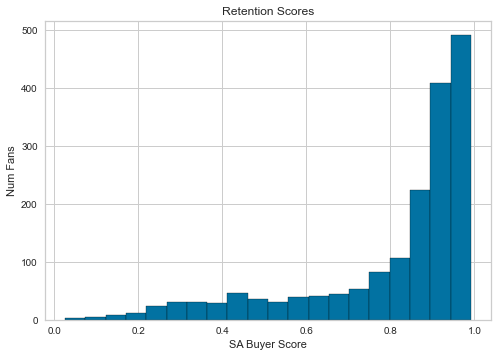

In [30]:
plt.hist(new_predictions["Score_1"], bins=20, edgecolor='black')
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.show()

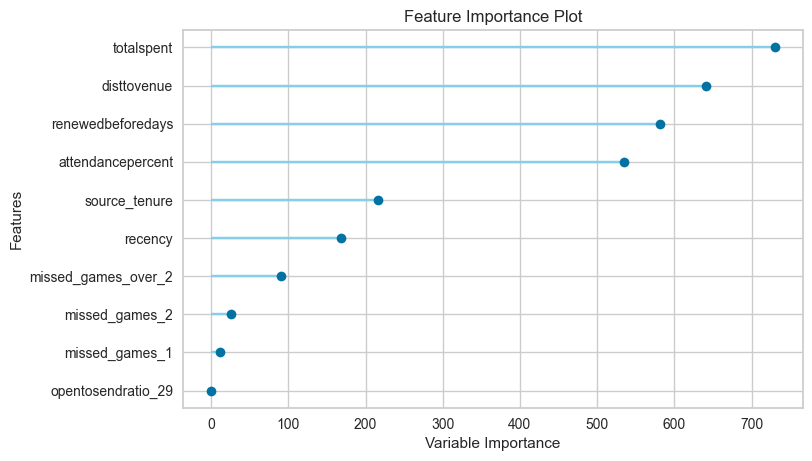

In [31]:
plot_model(final_model, plot='feature')

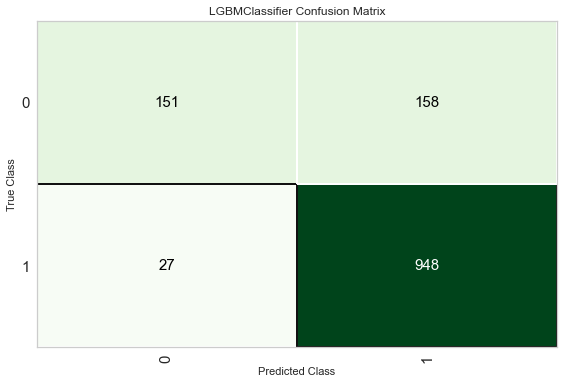

In [32]:
plot_model(final_model, plot='confusion_matrix')

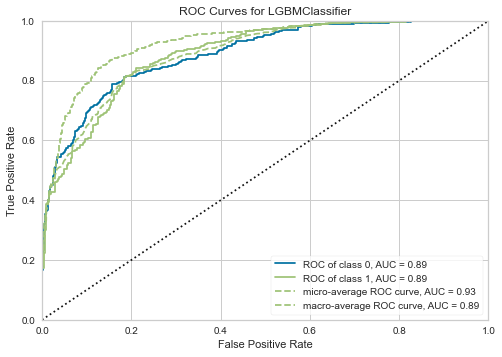

In [33]:
plot_model(final_model, plot='auc')

### Done